In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu4_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)

In [6]:
# df_study = df_study.loc[df_study.session < 100]
df_study

,itemno,item,itemno_old,freq,quantile,session
0,316,FARM,552,1161,8,0
1,477,LEOPARD,812,118,3,0
2,433,INSTRUCTOR,741,78,2,0
3,87,BOTTLE,153,1479,8,0
4,84,BOOT,150,149,3,0
...,...,...,...,...,...,...
995,58,BEEF,113,273,5,9
996,952,WARRIOR,1589,158,3,9
997,310,EYE,545,2284,9,9
998,722,RIVER,1194,1938,9,9


In [7]:
# df_test = df_test.loc[df_test.session < 100]
df_test

,itemno,item,itemno_old,freq,quantile,session,old
0,341,FORT,595,411,6,0,True
1,512,MANSION,864,156,3,0,True
2,66,BENCH,121,345,6,0,True
3,386,GUARD,667,658,7,0,False
4,57,BEE,112,185,4,0,True
...,...,...,...,...,...,...,...
1995,738,RUST,1219,67,1,9,False
1996,704,RASPBERRY,1168,37,0,9,False
1997,595,OWNER,993,570,7,9,False
1998,680,PRUNE,1134,18,0,9,False


### Run CMR-IA

In [8]:
s_mat = np.load('../Data/simu4_smat.npy')
# s_mat = np.load('../Data/simu4_smat_lsa.npy')

In [10]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.55,
    beta_rec = 0.1,
    beta_rec_post = 0.2,
    gamma_fc = 0.2,
    s_fc = 0.1,
    c_thresh = 0.25,
    a = 2800,
    b = 2.14,
    m = 10,
    n = 0.2,
)
params

{'beta_enc': 0.55,
 'beta_rec': 0.1,
 'beta_rec_new': 0.5,
 'beta_rec_post': 0.2,
 'beta_distract': None,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.1,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 8,
 'alpha': 4,
 'c_thresh': 0.25,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 10,
 'n': 0.2,
 'c1': 0.1,
 'gamma_fc': 0.2,
 'gamma_cf': 0.5}

In [8]:
df_simu = cmr.run_norm_recog_multi_sess(params,df_study,df_test,s_mat)
df_simu

CMR Time: 70.61454129219055


,session,itemno,s_resp,s_rt,csim
0,0,341,0.0,2368.296631,0.171753
1,0,512,1.0,2583.894531,0.287534
2,0,66,0.0,2194.039795,0.136040
3,0,386,0.0,1891.611328,0.066734
4,0,57,1.0,2693.983643,0.268037
...,...,...,...,...,...
199995,999,503,1.0,2481.678223,0.306395
199996,999,891,0.0,2244.363037,0.146637
199997,999,932,0.0,2591.661865,0.213869
199998,999,735,1.0,2164.278076,0.370342


In [9]:
df_simu = df_simu.merge(df_test,on=['session','itemno'])
df_simu

,session,itemno,s_resp,s_rt,csim,item,itemno_old,freq,quantile,old
0,0,341,0.0,2368.296631,0.171753,FORT,595,411,6,True
1,0,512,1.0,2583.894531,0.287534,MANSION,864,156,3,True
2,0,66,0.0,2194.039795,0.136040,BENCH,121,345,6,True
3,0,386,0.0,1891.611328,0.066734,GUARD,667,658,7,False
4,0,57,1.0,2693.983643,0.268037,BEE,112,185,4,True
...,...,...,...,...,...,...,...,...,...,...
199995,999,503,1.0,2481.678223,0.306395,LUNG,850,169,4,True
199996,999,891,0.0,2244.363037,0.146637,TORNADO,1485,34,0,False
199997,999,932,0.0,2591.661865,0.213869,VEHICLE,1553,383,6,False
199998,999,735,1.0,2164.278076,0.370342,RUG,1215,321,5,True


In [10]:
df_simu.groupby(['old']).s_resp.mean()

old
False    0.09233
True     0.79115
Name: s_resp, dtype: float64

### WFE

In [11]:
# get wordfreq quantile
with open('../Data/simu4_word_freq.pkl', 'rb') as inp:
    df = pickle.load(inp)
df

,item,itemno_old,itemno,freq,quantile
0,ABDOMEN,1,1,110,2
1,ACROBAT,4,2,17,0
2,ADULT,8,3,906,8
3,ALLEY,15,4,165,3
4,ALLIGATOR,16,5,12,0
...,...,...,...,...,...
979,YOKE,1632,980,12,0
980,YOLK,1633,981,47,1
981,YOUTH,1634,982,1159,8
982,ZIPPER,1636,983,24,0


In [12]:
freq_mean = df.groupby("quantile").freq.mean().to_numpy()
freq_mean = np.around(freq_mean, decimals=0)
freq_mean

array([  22.,   54.,   92.,  143.,  200.,  286.,  417.,  635., 1159.,
       4332.])

In [13]:
item2q = df[["itemno","quantile"]].set_index("itemno").to_dict()['quantile']
create_level = {0:"new lf", 1:"new hf", 2:"old lf", 3:"old hf"}

df_simu['quantile'] = df_simu.apply(lambda x: item2q[x["itemno"]], axis=1)
df_simu['hf'] = df_simu['quantile'] >= 5
df_simu['level'] = df_simu.apply(lambda x: create_level[x['old'] * 2 + x['hf']], axis = 1)
df_simu

,session,itemno,s_resp,s_rt,csim,item,itemno_old,freq,quantile,old,hf,level
0,0,341,0.0,2368.296631,0.171753,FORT,595,411,6,True,True,old hf
1,0,512,1.0,2583.894531,0.287534,MANSION,864,156,3,True,False,old lf
2,0,66,0.0,2194.039795,0.136040,BENCH,121,345,6,True,True,old hf
3,0,386,0.0,1891.611328,0.066734,GUARD,667,658,7,False,True,new hf
4,0,57,1.0,2693.983643,0.268037,BEE,112,185,4,True,False,old lf
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,999,503,1.0,2481.678223,0.306395,LUNG,850,169,4,True,False,old lf
199996,999,891,0.0,2244.363037,0.146637,TORNADO,1485,34,0,False,False,new lf
199997,999,932,0.0,2591.661865,0.213869,VEHICLE,1553,383,6,False,True,new hf
199998,999,735,1.0,2164.278076,0.370342,RUG,1215,321,5,True,True,old hf


In [14]:
# shifting decision criterion by word freq
b0 = 0.28
b1 = -0.01
df_simu['mean_freq'] = df_simu.apply(lambda x:freq_mean[x['quantile']], axis=1)
df_simu['criterion'] = df_simu.apply(lambda x:b0 + b1*np.log(x['mean_freq']), axis=1)
df_simu['s_resp'] = df_simu.apply(lambda x:1 if x['csim'] >= x['criterion'] else 0, axis=1)
df_simu

,session,itemno,s_resp,s_rt,csim,item,itemno_old,freq,quantile,old,hf,level,mean_freq,criterion
0,0,341,0,2368.296631,0.171753,FORT,595,411,6,True,True,old hf,417.0,0.219669
1,0,512,1,2583.894531,0.287534,MANSION,864,156,3,True,False,old lf,143.0,0.230372
2,0,66,0,2194.039795,0.136040,BENCH,121,345,6,True,True,old hf,417.0,0.219669
3,0,386,0,1891.611328,0.066734,GUARD,667,658,7,False,True,new hf,635.0,0.215464
4,0,57,1,2693.983643,0.268037,BEE,112,185,4,True,False,old lf,200.0,0.227017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,999,503,1,2481.678223,0.306395,LUNG,850,169,4,True,False,old lf,200.0,0.227017
199996,999,891,0,2244.363037,0.146637,TORNADO,1485,34,0,False,False,new lf,22.0,0.249090
199997,999,932,0,2591.661865,0.213869,VEHICLE,1553,383,6,False,True,new hf,417.0,0.219669
199998,999,735,1,2164.278076,0.370342,RUG,1215,321,5,True,True,old hf,286.0,0.223440


In [15]:
df_simu.groupby(["old","quantile"]).csim.mean()

old    quantile
False  0           0.196019
       1           0.200172
       2           0.190336
       3           0.183073
       4           0.186013
       5           0.177348
       6           0.175356
       7           0.168972
       8           0.160297
       9           0.158326
True   0           0.337606
       1           0.342045
       2           0.329410
       3           0.322981
       4           0.323229
       5           0.313547
       6           0.310617
       7           0.303824
       8           0.290993
       9           0.290716
Name: csim, dtype: float64

In [16]:
df_itemgp = pd.pivot_table(df_simu, values='s_resp', index=['itemno'],
                    columns=['old'],aggfunc = np.mean)
df_itemgp.columns = ['far','hr']
df_itemgp = df_itemgp.reset_index()
df_itemgp

,itemno,far,hr
0,1,0.010989,0.977528
1,2,0.000000,0.670213
2,3,0.000000,0.913043
3,4,0.000000,0.990196
4,5,0.669903,0.992063
...,...,...,...
979,980,0.000000,0.887850
980,981,0.575472,1.000000
981,982,0.000000,0.804124
982,983,0.027778,0.972222


In [17]:
df_itemgp = df_itemgp.merge(df,on=['itemno'])
df_itemgp

,itemno,far,hr,item,itemno_old,freq,quantile
0,1,0.010989,0.977528,ABDOMEN,1,110,2
1,2,0.000000,0.670213,ACROBAT,4,17,0
2,3,0.000000,0.913043,ADULT,8,906,8
3,4,0.000000,0.990196,ALLEY,15,165,3
4,5,0.669903,0.992063,ALLIGATOR,16,12,0
...,...,...,...,...,...,...,...
979,980,0.000000,0.887850,YOKE,1632,12,0
980,981,0.575472,1.000000,YOLK,1633,47,1
981,982,0.000000,0.804124,YOUTH,1634,1159,8
982,983,0.027778,0.972222,ZIPPER,1636,24,0


In [18]:
df_quantgp = df_itemgp.groupby(['quantile']).agg({'hr': 'mean', 'far': 'mean'}).reset_index()
df_quantgp['freq_mean'] = freq_mean
df_quantgp

,quantile,hr,far,freq_mean
0,0,0.893163,0.119800,22.0
1,1,0.891954,0.281099,54.0
2,2,0.873698,0.208344,92.0
3,3,0.879215,0.160464,143.0
4,4,0.888803,0.230687,200.0
5,5,0.840530,0.219091,286.0
6,6,0.873907,0.196947,417.0
7,7,0.857180,0.205338,635.0
8,8,0.797654,0.205158,1159.0
9,9,0.876802,0.246452,4332.0


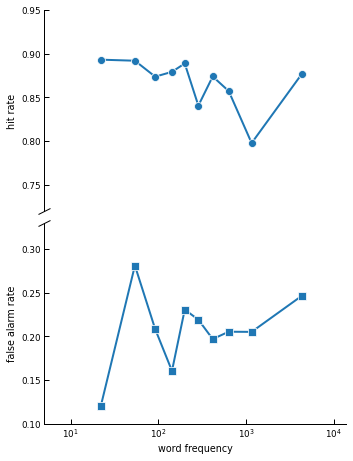

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,6.5))
fig.subplots_adjust(hspace=0.03)

sns.lineplot(data=df_quantgp, y='hr', x='freq_mean', ax=ax1, marker = 'o', color = 'C0', markersize = 8, linewidth = 2)
sns.lineplot(data=df_quantgp, y='far', x='freq_mean', ax=ax2, marker = 's', color = 'C0', markersize = 8, linewidth = 2)

ax1.set_ylim(0.72, 0.95)
ax1.set_yticks(np.arange(0.75,0.96,0.05))
ax2.set_ylim(0.1, 0.33)
ax2.set_yticks(np.arange(0.1,0.35,0.05))
ax1.tick_params(axis="y",direction="in")
ax1.tick_params(axis="x",direction="in")
ax2.tick_params(axis="y",direction="in")
ax2.tick_params(axis="x",direction="in")
plt.xscale('log')
plt.xlim(5, 14000)

ax1.spines.bottom.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax1.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False, 
    labelbottom=False,
    labeltop=False) 
ax2.minorticks_off()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot(0,0, transform=ax1.transAxes, **kwargs)
ax2.plot(0,1, transform=ax2.transAxes, **kwargs)

ax1.set_ylabel('hit rate')
ax1.set_xlabel(None)
ax2.set_ylabel('false alarm rate')
ax2.set_xlabel('word frequency')

plt.tight_layout(h_pad = 0)
plt.savefig('fig/simu4_WFE.pdf')
plt.show()

### Analysis

<AxesSubplot:xlabel='csim', ylabel='Probability'>

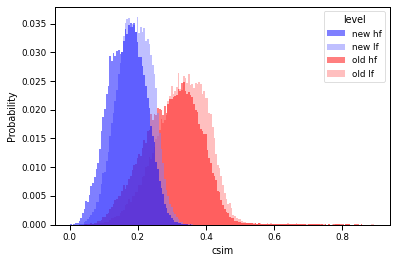

In [20]:
sns.histplot(data=df_simu, x="csim", hue = "level", hue_order = ["new hf", "new lf", "old hf", "old lf"], palette = [[0,0,1],[0.5,0.5,1],[1,0,0],[1,0.5,0.5]], stat = "probability", common_norm=False, edgecolor = None)
# plt.savefig('fig/simu4_csim.pdf')